# Part 1: Data Exploration & Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load and prepare data
df = pd.read_csv("eu_sdg_performance_data.csv")

id_like = {"Country", "year", "performance_tier", "sdgi_score"}
feature_cols = [c for c in df.columns if c not in id_like]

tier_col = "performance_tier"

Performance Tier Distribution:
  Needs Improvement (0): 83 observations
  Good Performers (1): 275 observations
  Leaders (2): 62 observations


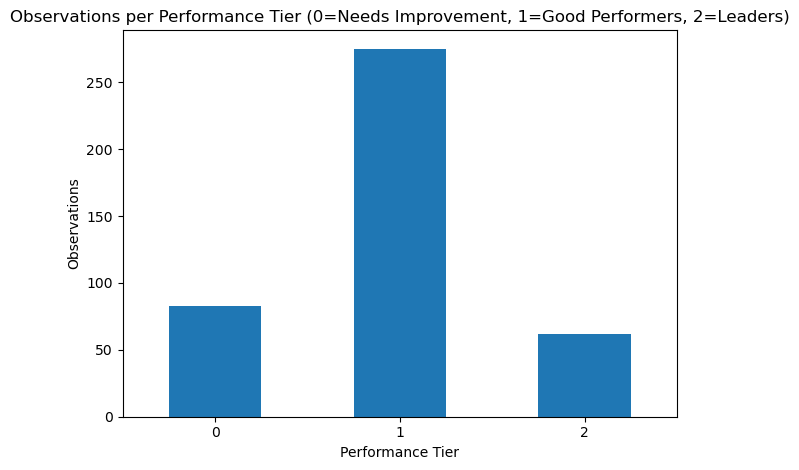

In [3]:
# Explore the target variable
tier_labels = {0: "Needs Improvement", 1: "Good Performers", 2: "Leaders"}
df["tier_label"] = df["performance_tier"].map(tier_labels)

tier_counts = df[tier_col].value_counts().sort_index()
print("Performance Tier Distribution:")
for tier, count in tier_counts.items():
    print(f"  {tier_labels[tier]} ({tier}): {count} observations")
    
# Distribution of observations per tier
plt.figure()
tier_counts.plot(kind="bar")
plt.title("Observations per Performance Tier (0=Needs Improvement, 1=Good Performers, 2=Leaders)")
plt.xlabel("Performance Tier")
plt.ylabel("Observations")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [4]:
# Compare Leaders (2) vs Needs Improvement (0): standardized median difference
leaders = df[df[tier_col] == 2]
needs_imp = df[df[tier_col] == 0]
std = df[feature_cols].std(numeric_only=True)

diffs = []
for c in feature_cols:
    med2 = leaders[c].median()
    med0 = needs_imp[c].median()
    s = std[c] if std[c] != 0 else np.nan
    eff = (med2 - med0) / s if pd.notna(s) else np.nan
    diffs.append((c, med0, med2, med2 - med0, eff))
diff_df = pd.DataFrame(diffs, 
                       columns=["feature", "median_tier0", "median_tier2", "median_diff", 
                                "stdzd_median_diff"]).sort_values(by="stdzd_median_diff", ascending=False)
print("\nTop standardized median differences (Tier2 − Tier0):")
print(diff_df.head(10))


Top standardized median differences (Tier2 − Tier0):
          feature  median_tier0  median_tier2  median_diff  stdzd_median_diff
6       sdg16_cpi         42.00         85.00        43.00           2.723727
10     sdg4_adult          5.00         26.00        21.00           2.470019
4    sdg9_digital         35.00         69.00        34.00           2.374417
3       sdg9_eurd          1.00          3.00         2.00           2.212718
7       sdg16_rsf         68.00         90.00        22.00           2.092426
0     sdg8_income      14712.00      26246.00     11534.00           1.890746
5      sdg9_bband         81.00         95.00        14.00           1.795613
9   sdg4_tertiary         34.00         46.00        12.00           1.401136
11   sdg7_eurenew         21.00         44.50        23.50           1.326950
12   sdg13_co2gcp          5.05          6.34         1.29           0.572972


<i>Leaders vs Needs Improvement</i><br>
The top rows highlight where Leaders most outperform Needs Improvement.

In [5]:
from scipy.stats import spearmanr

# Compute Spearman correlations with performance_tier
rho = []
for c in feature_cols:
    valid = df[[c, tier_col]].dropna()
    if len(valid) > 2 and valid[c].nunique() > 1:
        r, p = spearmanr(valid[c], valid[tier_col])
        rho.append((c, r, p, len(valid)))
spearman_df = pd.DataFrame(rho, 
                           columns=["feature", "spearman_rho", "p_value", 
                                    "n"]).sort_values(by="spearman_rho", key=np.abs, ascending=False)
print("\nTop Spearman correlations:")
print(spearman_df.head(10))


Top Spearman correlations:
         feature  spearman_rho       p_value    n
6      sdg16_cpi      0.737336  3.259258e-73  420
4   sdg9_digital      0.683794  8.262970e-58  410
10    sdg4_adult      0.676327  1.832153e-57  420
7      sdg16_rsf      0.669913  5.012987e-56  420
3      sdg9_eurd      0.669007  7.950219e-56  420
14    sdg10_gini     -0.571340  9.207700e-38  420
0    sdg8_income      0.555833  1.285247e-34  410
13   sdg5_empgap     -0.521056  6.492627e-30  410
5     sdg9_bband      0.495579  2.050253e-27  420
2    sdg8_inwork     -0.462464  1.203006e-23  420


The table shows the strongest monotonic relationships with the target.

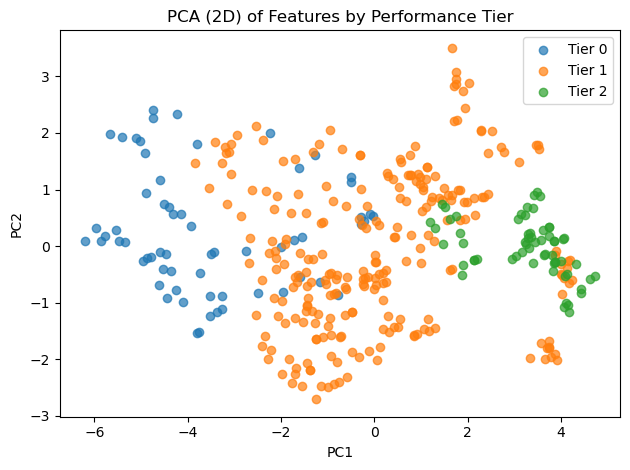

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# PCA scatter: are there clear patterns separating tiers?
X = df[feature_cols].copy().dropna()
rows_used = X.index.intersection(df.index)
y_for_pca = df.loc[rows_used, tier_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
y_vals = y_for_pca.values.astype(float)
unique_tiers = [t for t in np.unique(y_vals) if not np.isnan(t)]
for t in unique_tiers:
    idx = np.where(y_vals == t)[0]
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Tier {int(t)}", alpha=0.7)
plt.title("PCA (2D) of Features by Performance Tier")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

The PCA plot shows partial but noticeable separation: Tier 2 (Leaders) clusters on one side, Tier 0 (Needs Improvement) on the other, with Tier 1 (Good Performers) overlapping both—consistent with a smooth performance gradient rather than hard clusters.

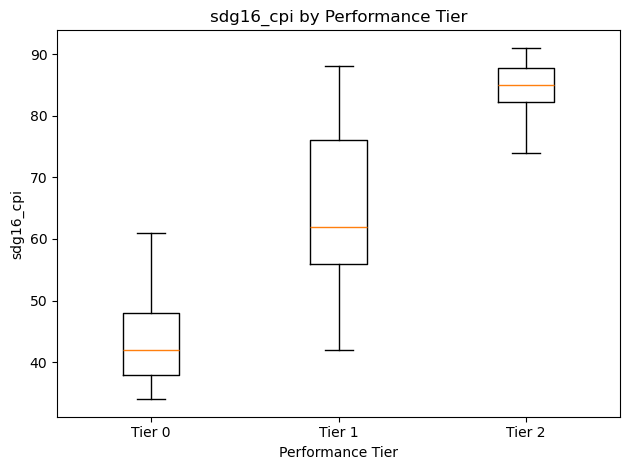

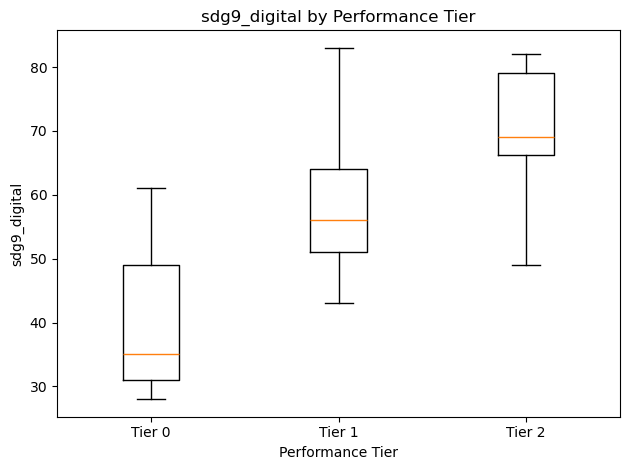

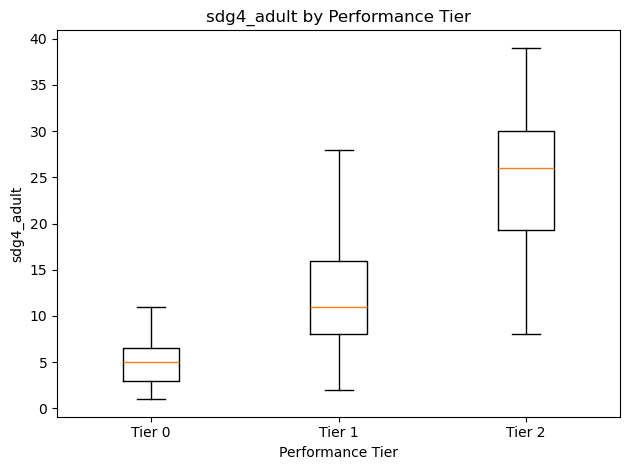

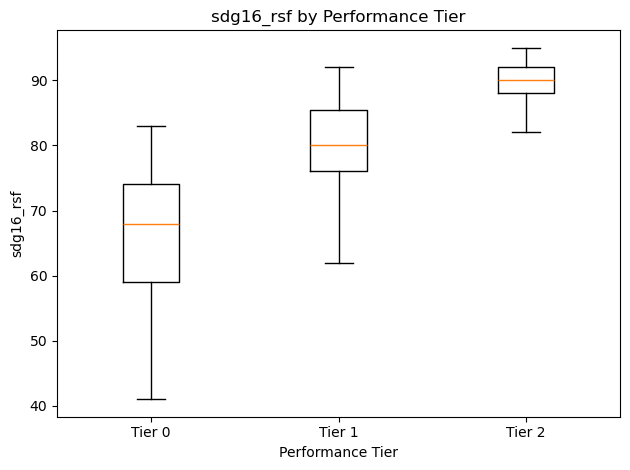

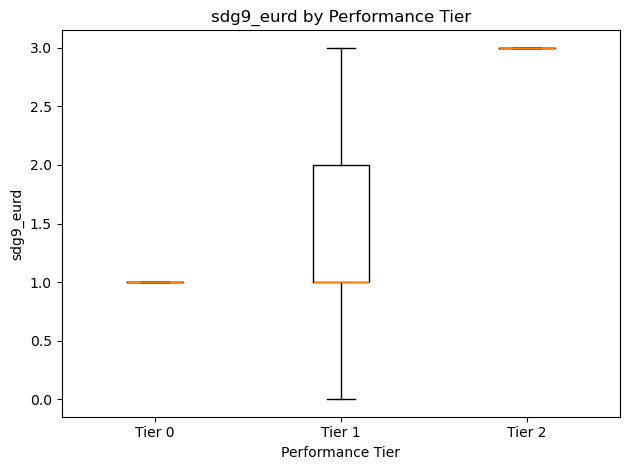

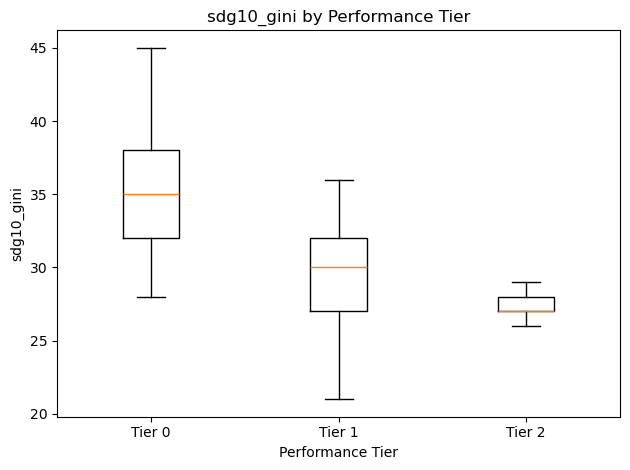

In [7]:
# Boxplots for top 6 discriminative features (by |Spearman rho|)
top_features = list(spearman_df.head(6)["feature"])
for feat in top_features:
    plt.figure()
    data = [df[df[tier_col] == t][feat].dropna().values for t in [0, 1, 2]]
    plt.boxplot(data, tick_labels=["Tier 0", "Tier 1", "Tier 2"], showfliers=False)
    plt.title(f"{feat} by Performance Tier")
    plt.xlabel("Performance Tier")
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()

In [8]:
expected_obs = "~490 (49 countries × 10 years)"
actual_obs = len(df)
actual_countries = df['Country'].nunique()
years_detected = df['year'].nunique()

print(f"\nDataset shape: {df.shape}")
print(f"Countries: {actual_countries}, Years: {years_detected}, Observations: {actual_obs} (expected {expected_obs})")



Dataset shape: (420, 20)
Countries: 42, Years: 10, Observations: 420 (expected ~490 (49 countries × 10 years))
